In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import plotly.express as px
import pdb
import random
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'))
n_cats = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'))
n_images = [n_dogs, n_cats]
px.pie(names=class_names,values=n_images)

In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

In [5]:
CAT_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

print(len(os.listdir(CAT_DIR)))
print(len(os.listdir(DOG_DIR)))

0
0
0
0
0
0
12501
12501


In [7]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
    
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)

    shuffled_files = random.sample(files, len(files))
    split = int(0.9 * len(shuffled_files))
    
    train = shuffled_files[:split]
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
    if include_test_split:
            validation = shuffled_files[split:split_valid_test] # validation split
            test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]
        
    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) 
    print("Split sucessful!")

In [8]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


In [9]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

11250
11250
625
625
625
625


In [10]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)

Why can't it be categorical instead of binary?

In [11]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22499 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


In [12]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [13]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = next(generator)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

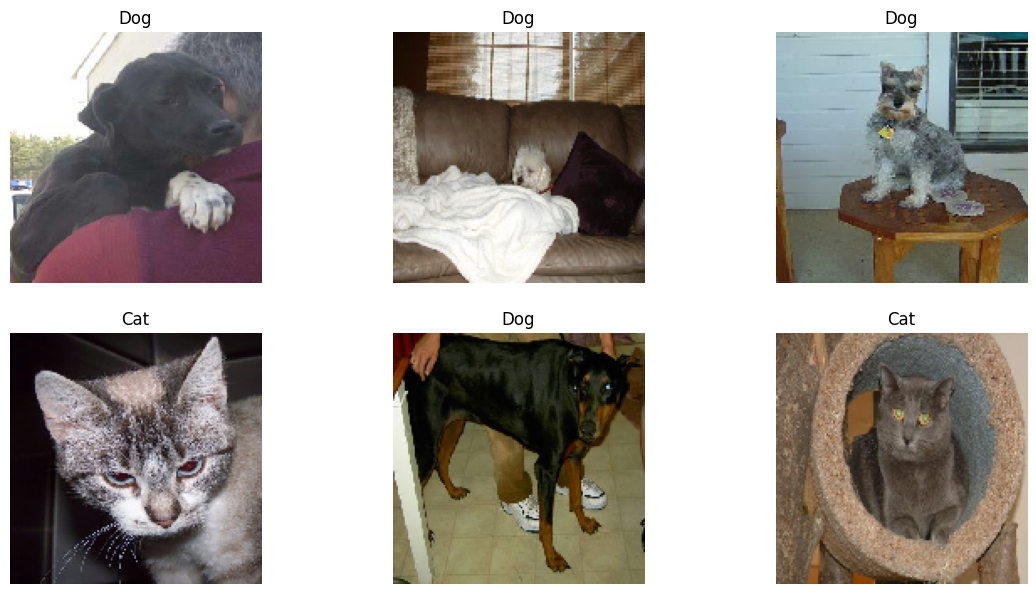

In [14]:
plot_data(train_generator,7)

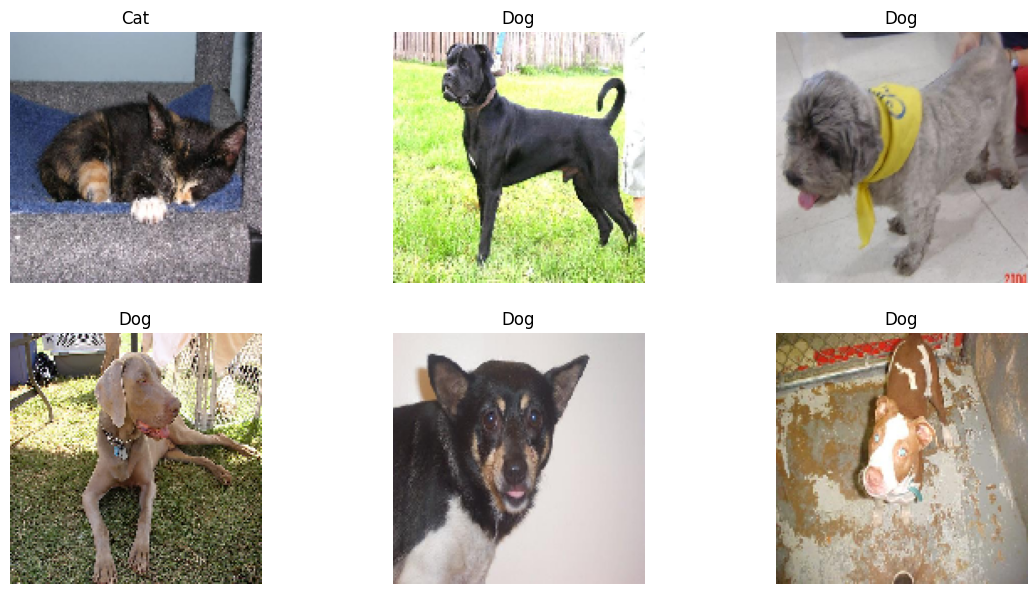

In [15]:
plot_data(validation_generator,7)

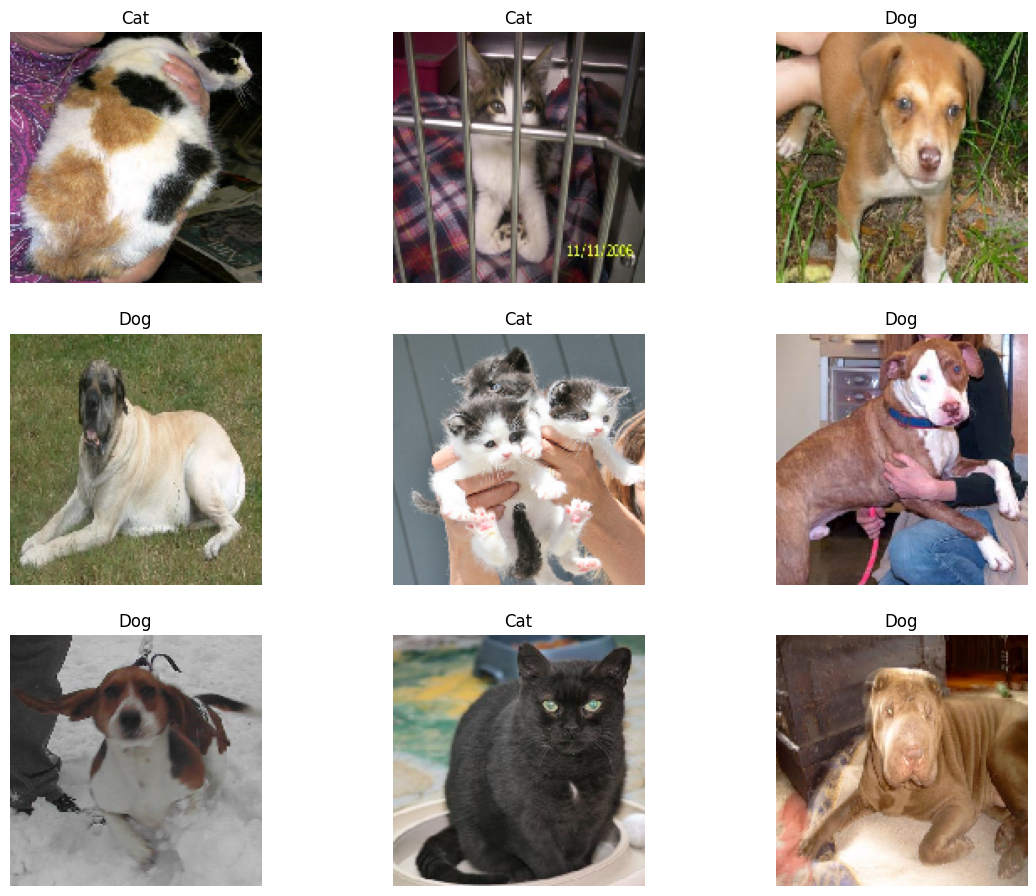

In [16]:
plot_data(test_generator, 10)

In [17]:
inputs = Input(shape=(150,150,3))
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = Conv2D(256, (3,3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)

x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 837,121 (3.19 MB)

 Trainable params: 837,121 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

The Param column in model.summary() represents the number of trainable parameters (weights and biases) for each layer in a Keras model. These parameters are what the model learns during training.

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
r = model.fit(
        train_generator,
        epochs=2,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?

/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning:

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



308/352 ━━━━━━━━━━━━━━━━━━━━ 5:15 7s/step - accuracy: 0.4988 - loss: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning:

Truncated File Read



352/352 ━━━━━━━━━━━━━━━━━━━━ 2595s 7s/step - accuracy: 0.4989 - loss: 0.0000e+00 - val_accuracy: 0.5004 - val_loss: 0.0000e+00
Epoch 2/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 2598s 7s/step - accuracy: 0.4978 - loss: 0.0000e+00 - val_accuracy: 0.5004 - val_loss: 0.0000e+00
